/tmp/ipython-input-3555709326.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2024-10-01", end="2025-10-25")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3555709326.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(nifty["Close"].iloc[-1])  # Last closing price
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/tmp/ipython-input-3555709326.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float

📈 NIFTY 50 Latest Close: 25795.15
⚡ Annualized Volatility (σ): 0.1268
💰 Call Option Price (30 days expiry): ₹451.73

📊 Greeks:
Delta: 0.570092
Gamma: 0.000419
Theta: -3238.236176
Vega: 29.046204
Rho: 11.715520


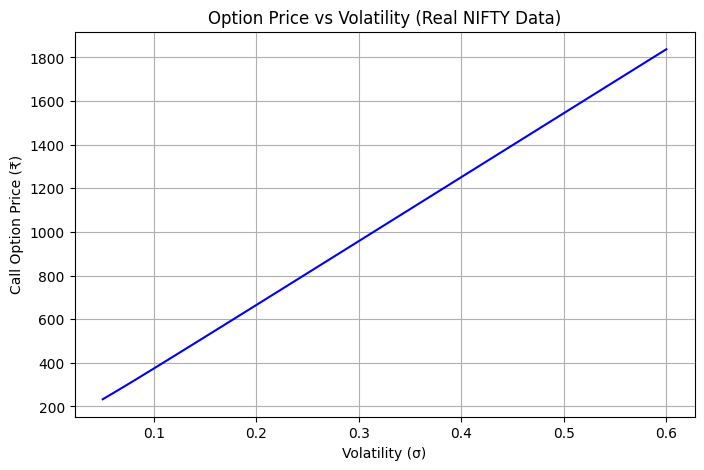

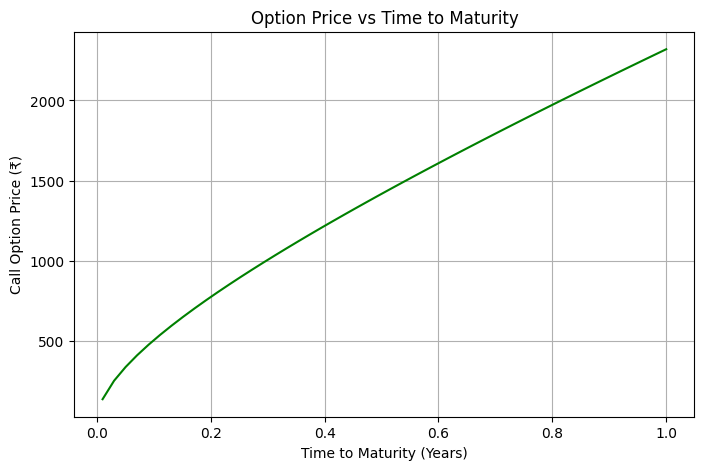

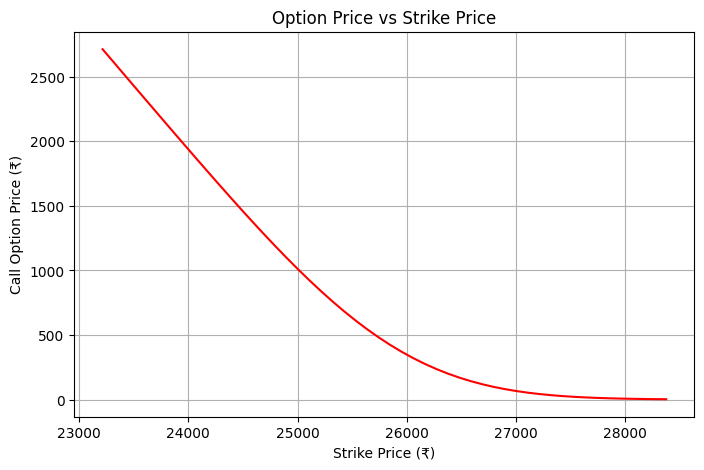

In [5]:
# ========================================
# Real Data Black-Scholes Model for NIFTY
# ========================================

!pip install yfinance pandas numpy matplotlib scipy -q

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ------------------------------
# Step 1: Define Functions
# ------------------------------

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price."""
    # Ensure inputs are floats
    S = float(S)
    K = float(K)
    T = float(T)
    r = float(r)
    sigma = float(sigma)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

def calculate_greeks(S, K, T, r, sigma):
    """Calculate Greeks for a call option."""
    # Ensure inputs are floats
    S = float(S)
    K = float(K)
    T = float(T)
    r = float(r)
    sigma = float(sigma)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * norm.cdf(d2))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)

    return {
        'Delta': float(delta),
        'Gamma': float(gamma),
        'Theta': float(theta),
        'Vega': float(vega) / 100,  # per 1% change
        'Rho': float(rho) / 100     # per 1% change
    }

# ------------------------------
# Step 2: Fetch Real NIFTY Data
# ------------------------------

nifty = yf.download("^NSEI", start="2024-10-01", end="2025-10-25")

# Make sure S is a float, not Series
S = float(nifty["Close"].iloc[-1])  # Last closing price
K = round(S)                        # Strike = current price
r = 0.07                            # 7% annual risk-free rate
sigma = float(np.std(np.log(nifty["Close"]/nifty["Close"].shift(1))) * np.sqrt(252))  # annualized volatility
T = 30/365                          # 30 days to expiry

# ------------------------------
# Step 3: Compute Price + Greeks
# ------------------------------

call_price = float(black_scholes_price(S, K, T, r, sigma, option_type='call'))
greeks = calculate_greeks(S, K, T, r, sigma)

print(f"📈 NIFTY 50 Latest Close: {S:.2f}")
print(f"⚡ Annualized Volatility (σ): {sigma:.4f}")
print(f"💰 Call Option Price (30 days expiry): ₹{call_price:.2f}\n")

print("📊 Greeks:")
for k, v in greeks.items():
    print(f"{k}: {v:.6f}")

# ------------------------------
# Step 4: Visualize Relationships
# ------------------------------

# Option Price vs Volatility
volatilities = np.linspace(0.05, 0.6, 50)
prices_vol = [black_scholes_price(S, K, T, r, vol) for vol in volatilities]

plt.figure(figsize=(8, 5))
plt.plot(volatilities, prices_vol, color='blue')
plt.title("Option Price vs Volatility (Real NIFTY Data)")
plt.xlabel("Volatility (σ)")
plt.ylabel("Call Option Price (₹)")
plt.grid(True)
plt.show()

# Option Price vs Time to Maturity
T_values = np.linspace(0.01, 1, 50)
prices_T = [black_scholes_price(S, K, t, r, sigma) for t in T_values]

plt.figure(figsize=(8, 5))
plt.plot(T_values, prices_T, color='green')
plt.title("Option Price vs Time to Maturity")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Call Option Price (₹)")
plt.grid(True)
plt.show()

# Option Price vs Strike Price
K_values = np.linspace(S*0.9, S*1.1, 50)
prices_K = [black_scholes_price(S, k, T, r, sigma) for k in K_values]

plt.figure(figsize=(8, 5))
plt.plot(K_values, prices_K, color='red')
plt.title("Option Price vs Strike Price")
plt.xlabel("Strike Price (₹)")
plt.ylabel("Call Option Price (₹)")
plt.grid(True)
plt.show()